#**Mount the drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Get GPU support**

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# **Importing Libraries**

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# **Load Flair's predicted Dataset**

In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/FYP Datasets/Flair_Sentiment_Predictions.csv")
df.head()

,address,categories,name,reviews.rating,reviews.text,emoticon,Polarity,Predicted_Sentiment,Predict_VS_Rating
0,415 Horner Avenue,"Shopping, Food, Organic Stores, Specialty Food...",Front Door Organics,5.0,"I love this service, a client had referred me ...",:),POSITIVE (0.9996),Positive,True
1,855 S Grand Central Pkwy,"Accessories, Shopping, Fashion, Men's Clothing...",Lacoste Outlet Las Vegas,4.0,They have some good markdowns and prices here....,:),POSITIVE (0.9974),Positive,True
2,855 S Grand Central Pkwy,"Accessories, Shopping, Fashion, Men's Clothing...",Lacoste Outlet Las Vegas,3.0,"Red, orange, yellow, green, blue, purple, pink...",:),POSITIVE (0.8543),Positive,True
3,3463 Sheppard Ave E,"Flowers & Gifts, Shopping, Florists",Helen Blakey Flowers,3.0,Got these for my birthday and they were beauti...,:),POSITIVE (1.0),Positive,True
4,2710 W Thunderbird Rd,"Shopping, Fashion, Men's Clothing, Shoe Stores",Cowtown Boots,5.0,I spent $200 on boots fore months ago here and...,:(,NEGATIVE (0.9999),Negative,False


# **Data Preprocessing**

## Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le_sentiment=LabelEncoder()

In [ ]:
df["new_sentiment"]=le_sentiment.fit_transform(df["Predicted_Sentiment"])
df.head()

,address,categories,name,reviews.rating,reviews.text,emoticon,Polarity,Predicted_Sentiment,Predict_VS_Rating,new_sentiment
0,415 Horner Avenue,"Shopping, Food, Organic Stores, Specialty Food...",Front Door Organics,5.0,"I love this service, a client had referred me ...",:),POSITIVE (0.9996),Positive,True,1
1,855 S Grand Central Pkwy,"Accessories, Shopping, Fashion, Men's Clothing...",Lacoste Outlet Las Vegas,4.0,They have some good markdowns and prices here....,:),POSITIVE (0.9974),Positive,True,1
2,855 S Grand Central Pkwy,"Accessories, Shopping, Fashion, Men's Clothing...",Lacoste Outlet Las Vegas,3.0,"Red, orange, yellow, green, blue, purple, pink...",:),POSITIVE (0.8543),Positive,True,1
3,3463 Sheppard Ave E,"Flowers & Gifts, Shopping, Florists",Helen Blakey Flowers,3.0,Got these for my birthday and they were beauti...,:),POSITIVE (1.0),Positive,True,1
4,2710 W Thunderbird Rd,"Shopping, Fashion, Men's Clothing, Shoe Stores",Cowtown Boots,5.0,I spent $200 on boots fore months ago here and...,:(,NEGATIVE (0.9999),Negative,False,0


## Data filtering

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()


    return text

# Install transformers

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 8.4MB/s 
     |████████████████████████████████| 3.3MB 48.2MB/s 
     |████████████████████████████████| 870kB 54.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=05fda1806b1fd909a2406dca6bcca796f1473816b200907da933707a60b4aa66
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


# **Set BERT**

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 512

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

## Set parameters of BERT

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

## Create BERT class

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 21.2 ms, sys: 1.75 ms, total: 22.9 ms
Wall time: 24.6 ms


## Function to put model in evaluation mode

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

# Function for visualization of predictions

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Preprocessing of data to feed to BERT

In [ ]:
# Run `preprocessing_for_bert` on the prediction set
print('Tokenizing data...')
pre_inputs, pre_masks = preprocessing_for_bert(df['reviews.text'])

# Create the DataLoader for our prediction set
pre_dataset = TensorDataset(pre_inputs, pre_masks)
pre_sampler = SequentialSampler(pre_dataset)
pre_dataloader = DataLoader(pre_dataset, sampler=pre_sampler, batch_size=10)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# **Load the saved BERT trained Model**

In [ ]:
model=torch.load("/content/drive/MyDrive/FYP Datasets/trained_model.pth")

# **Testing**

## Get predictions

In [ ]:
#Compute predicted probabilities on the test set
probs = bert_predict(model, pre_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of predicted non-negative: ", preds.sum())

Number of predicted non-negative:  315


In [ ]:
y_val=df['new_sentiment']

In [ ]:
np.array(y_val)

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,

## Visulaization of predicted Results

AUC: 0.9555
Accuracy: 92.00%


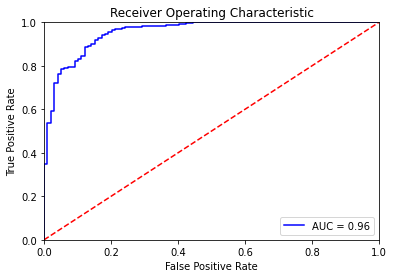

In [ ]:
# Evaluate the Bert classifier
evaluate_roc(probs,y_val)